# Comparison of approximate KL divergence estimator and asymptotically exact KL divergence estimator

## Approximate KL divergence

Currently the pints.toy.GaussianLogPDF implements an approximate KL divergence estimator which assumes that the inferred distribution (provided in form chain samples) has a Gaussian shape. 

Pros:

1. This approximation has the advantage that the KL divergence computation reduces to the computation of the mean and the variance of the inferred distribution.
2. It scales well to large dimensions.

Cons:

1. Assuming that the inferred distribution has a Gaussian shape defeats the purpose of using the KL divergence as a metric, and really boils down to only comparing the mean and the variance of the distributions.
2. Works only for Gaussian distribution.

## Asymptotically exact KL divergence

Provided that the test dsitribution implements a sample routine we can easily compute an analytically exact estimate for the KL divergence

\begin{equation}
    \hat{D}(f || g) = \frac{1}{n}\sum _{i=1}^n \log \frac{f(x_i)}{g(x_i)},
\end{equation}

whose error variance decays as $\text{Var}\left[ \hat{D}(f || g)\right] = \frac{1}{n} \text{Var}\left[ \log \frac{f(x)}{g(x)} \right] $.

Pros:

1. Reflects the true distributional differences.
2. Can be used for any distributional shape.
3. Error of estimate can be controlled.

Cons:

1. Likely only feasible for reasonably low dimensional problems (but functional testing so far is not going beyond 2 dimensions?)
2. Scores of inferred dsitribution $g(x)$ need to be constructed from bins (if sampler does not explore tails well, we'd get an infinite KL divergence, because bins will provide a hard cut off)

## Example I: 2 dimensional Gaussian distribution and HarrioBardenetACMC

### Infer parameters

In [20]:
import pints
import pints.toy

# Define pdf 
# (prior is only used to sample starting positions for chains)
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=3),
    pints.GaussianLogPrior(mean=0, sd=3))

# Set up hyperparameters
initial_parameters = log_prior.sample(n=10)
n_chains = 10
n_iterations = 4000
method = pints.HaarioBardenetACMC
is_run_parallel = True


# Set up problem
sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=method)
sampler.set_max_iterations(n_iterations)
sampler.set_parallel(is_run_parallel)
sampler.set_log_to_screen(False)

# Sample
chains = sampler.run()

### Visualise traces

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------
param 1  0.02    1.01    -1.97   -0.68  0.02   0.70   2.01     1.00    2894.97
param 2  -0.03   1.03    -2.12   -0.72  -0.00  0.66   1.94     1.00    2669.43


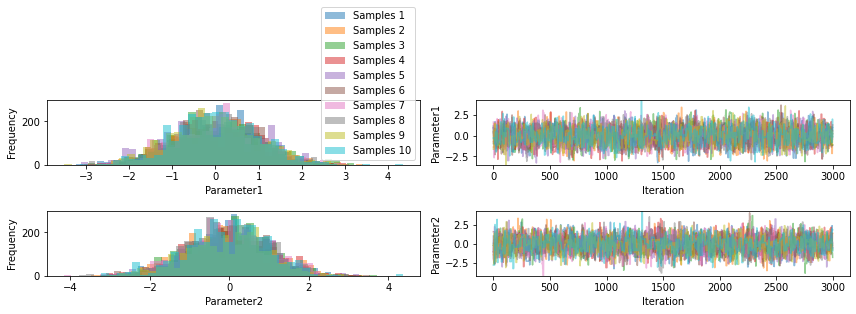

In [23]:
import matplotlib.pyplot as plt
import pints.plot

# Set warmup iterations
warmup = 1000

# Show summary
print(pints.MCMCSummary(chains=chains[:, warmup:]))

# Plot traces
fig = pints.plot.trace(chains[:, warmup:])
plt.show()